In [1]:
using LinearAlgebra
using Plots

In [2]:
pts = [(0,0),(1,1),(2,3),(1,4),(0,4),(-1,3),(0,1),(1,0)]


8-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (1, 1)
 (2, 3)
 (1, 4)
 (0, 4)
 (-1, 3)
 (0, 1)
 (1, 0)

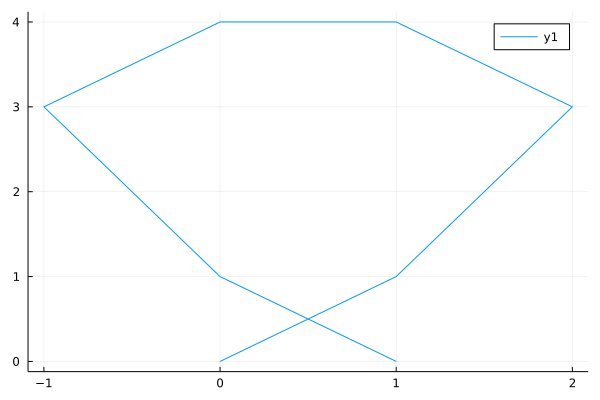

In [3]:
plot(pts)

In [4]:
function bi(t, i, n)
    return binomial(n, i) * (t^i) * ((1-t)^(n-i))
end

bi (generic function with 1 method)

In [5]:
function bezier(pts, num=100)
    t = LinRange(0, 1, num)
    display(t)
    n = length(pts)
    B = zeros(Float64, (num, 2))
    for ti=1:num
        for i=1:n
            c = bi(t[ti], i-1, num)
            B[ti, 1] += c * pts[i][1]
            B[ti, 2] += c * pts[i][2]
        end
    end
    B[1, 1] = pts[1][1]
    B[1, 2] = pts[1][2]
    B[num, 1] = pts[n][1]
    B[num, 1] = pts[n][1]
    return B
end

bezier (generic function with 2 methods)

In [6]:
x = bezier(pts, 1000)
x

1000-element LinRange{Float64, Int64}:
 0.0,0.001001,0.002002,0.003003,0.004004,…,0.996997,0.997998,0.998999,1.0

1000×2 Matrix{Float64}:
 0.0        0.0
 0.794912   1.23737
 0.960388   2.28847
 0.741594   2.74565
 0.463178   2.6503
 0.269579   2.22109
 0.169019   1.67957
 0.123766   1.17315
 0.100471   0.76889
 0.0823264  0.47821
 ⋮          
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.0        0.0
 1.0        0.0

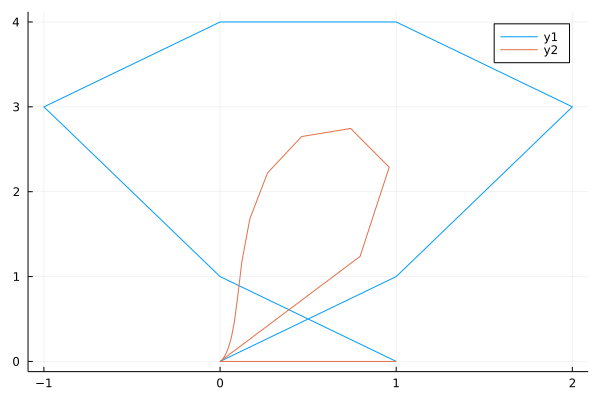

In [7]:
plot(pts)
plot!(x[:, 1], x[:, 2])

In [16]:
pts_ = zeros((length(pts), 2))
for i=1:length(pts)
    pts_[i,1] = pts[i][1]
    pts_[i,2] = pts[i][2]
end

In [9]:
pts_

8×2 Matrix{Float64}:
  0.0  0.0
  1.0  1.0
  2.0  3.0
  1.0  4.0
  0.0  4.0
 -1.0  3.0
  0.0  1.0
  1.0  0.0

In [10]:
prod(pts_[:, 1])

-0.0

In [11]:
# recursive

function rec_bez(pts, num)
    t = LinRange(0, 1, num)
    n = length(pts)
    B = zeros(Float64, (num, 2))
    # B[1, 1] = pts[1][1]
    # B[1, 2] = pts[1][2]
    for ti=1:num
        B[ti, :] = deCasteljau(t[ti], pts)
    end
    return B
end

rec_bez (generic function with 1 method)

In [12]:
function deCasteljau(t, pts)
    B = deepcopy(pts)
    n = size(pts)[1]
    for j=1:n
        for k=1:n-j
            B[k, :] = B[k, :] * (1-t) + B[k+1, :] * t
        end
    end
    return B[1, :]
end

deCasteljau (generic function with 1 method)

In [32]:
its = 100

100

In [33]:
x = rec_bez(pts_, its)

100×2 Matrix{Float64}:
 0.0        0.0
 0.0706364  0.0727783
 0.14086    0.149419
 0.210288   0.229515
 0.278571   0.312675
 0.345388   0.398525
 0.410449   0.486705
 0.47349    0.576871
 0.534274   0.668692
 0.59259    0.761854
 ⋮          
 0.465726   0.668692
 0.52651    0.576871
 0.589551   0.486705
 0.654612   0.398525
 0.721429   0.312675
 0.789712   0.229515
 0.85914    0.149419
 0.929364   0.0727783
 1.0        0.0

In [34]:
n = size(pts_)[1] - 1

pts_dx = [n.*(pts_[i+1, j]-pts_[i, j]) for i=1:n, j=1:2]

7×2 Matrix{Float64}:
  7.0    7.0
  7.0   14.0
 -7.0    7.0
 -7.0    0.0
 -7.0   -7.0
  7.0  -14.0
  7.0   -7.0

In [35]:
dx = rec_bez(pts_dx, its)

100×2 Matrix{Float64}:
 7.0       7.0
 6.97914   7.4031
 6.91881   7.76505
 6.82222   8.08751
 6.69248   8.37207
 6.53252   8.62029
 6.34515   8.83367
 6.13304   9.01368
 5.89875   9.16173
 5.6447    9.27919
 ⋮        
 5.89875  -9.16173
 6.13304  -9.01368
 6.34515  -8.83367
 6.53252  -8.62029
 6.69248  -8.37207
 6.82222  -8.08751
 6.91881  -7.76505
 6.97914  -7.4031
 7.0      -7.0

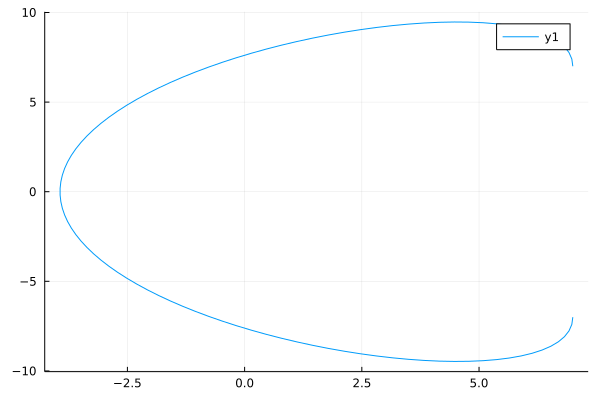

In [36]:
plot(dx[:, 1], dx[:, 2])

In [46]:
function f(t, s, pts)
    x1, y1 = deCasteljau(t, pts)
    x2, y2 = deCasteljau(s, pts)
    return [x1 - x2, y1 - y2]
end

function Jf(t, s, pts)
    x1, y1 = deCasteljau(t, pts)
    x2, y2 = deCasteljau(s, pts)
    return [x1 -x2; y1 -y2]
end

Jf (generic function with 2 methods)

pts: t (x, y)
 0.0750643506:(0.5000000000, 0.6162957793)
 0.9249356494:(0.5000000000, 0.6162957793)

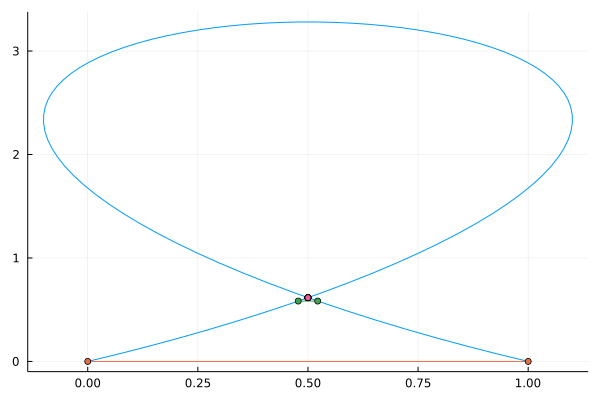

In [64]:
# f(t, s) = [x[t,1] - x[s,1], x[t,2] - x[s,2]]
# Jf(t, s) = [dx[t,1]  -dx[s,1]; dx[t,2]  -dx[s,2]]
plot(x[:, 1], x[:, 2])
t0 = 0; s0 = 1
x1, y1 = deCasteljau(t0, pts_)
x2, y2 = deCasteljau(s0, pts_)
plot!([x1, x2], [y1, y2], marker=:circle)
for i=1:5
  t0, s0 = [t0, s0] - Jf(t0, s0, pts_dx)\f(t0, s0, pts_)
  x1, y1 = deCasteljau(t0, pts_)
  x2, y2 = deCasteljau(s0, pts_)
  plot!([x1, x2], [y1, y2], marker=:circle)
end
@printf("pts: t (x, y)\n %.10f:(%.10f, %.10f)\n %.10f:(%.10f, %.10f)", t0, x1, y1, s0, x2, y2)

plot!(legend=false)


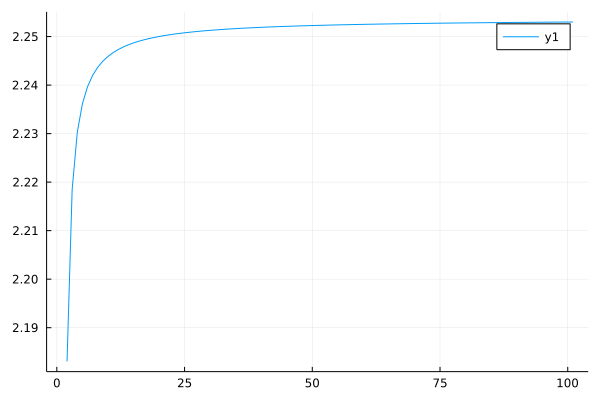

In [75]:
# integrate

# trapeziod

function dF(t, pts)
    x, y = deCasteljau(t, pts)
    return [x, y]#[-y, x]
end

function f(t, pts)
    x, y = deCasteljau(t, pts)
    return [-y, x]
end

Is = []

for j=0:50:5000
    I = 0
    steps = j
    a = t0
    h = (s0-t0)/steps
    b = a + h
    for i=0:steps
        da = dot(f(a, pts_), dF(a, pts_dx))
        db = dot(f(b, pts_), dF(b, pts_dx))
        cI = h * ((da + db) / 2)
        # display(cI)
        I += cI
        a = b
        b += h 
    end
    I /= 2
    append!(Is, I)
end

plot(Is)


In [56]:
using Printf

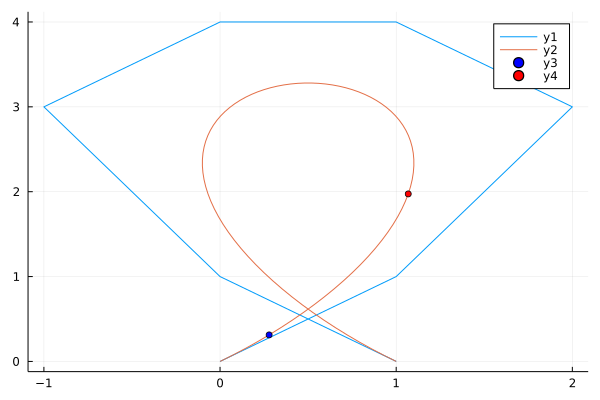

In [37]:
plot(pts)
plot!(x[:, 1], x[:, 2])
scatter!([x[s[id-1], 1]], [x[s[id-1], 2]], color=:blue)
scatter!([x[s[id], 1]], [x[s[id], 2]], color=:red)

In [37]:
function animate_bezier(px,py;steps=100)
    n = length(px)-1
    # saving all in between de Casteljau points
    bs = [zeros(2,r) for r=n+1:-1:0]
    # base case Bézier points
    bs[1][1,:] = px 
    bs[1][2,:] = py
    points = zeros(steps,2)
    colors = [:green,:orange,:red,:yellow, :pink, :blue, :purple, :lightgreen] 
    if length(colors) < n
        return ErrorException("add more colors!")
    end
    c = 1
    anim = @animate for t in LinRange(0,1,steps)
        plot(;size=(700,500), axisratio=:equal, legend=false)
        plot!(px, py, linetype=:scatter)
        for i=1:n
            for j=0:n-i   
                # linear interpolation between twp ponts                   
                new_b = (1-t)*bs[i][:,j+1]+t*bs[i][:,j+2]
                bs[i+1][:,j+1] = new_b
                # drawing the line for linear interpolation as well as the specific point for t
                plot!(bs[i][1,j+1:j+2],bs[i][2,j+1:j+2], legend=false, color=colors[i])
                plot!([new_b[1]],[new_b[2]], linetype=:scatter, legend=false, color=colors[i])
                if i == n
                    points[c,:] = [new_b[1],new_b[2]]
                    # draw the curve until point t = LinRange(0,1,steps)[c]
                    plot!(points[1:c,1],points[1:c,2], color=:black)
                    c += 1
                end
            end
        end
    end
    gif(anim, "bezier_d2.gif", fps=30)
end

animate_bezier (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/janja/faks/nm/nummat-2122/src/bezier_d2.gif
└ @ Plots /home/janja/.julia/packages/Plots/mnkn4/src/animation.jl:114


Plots.AnimatedGif("/home/janja/faks/nm/nummat-2122/src/bezier_d2.gif")
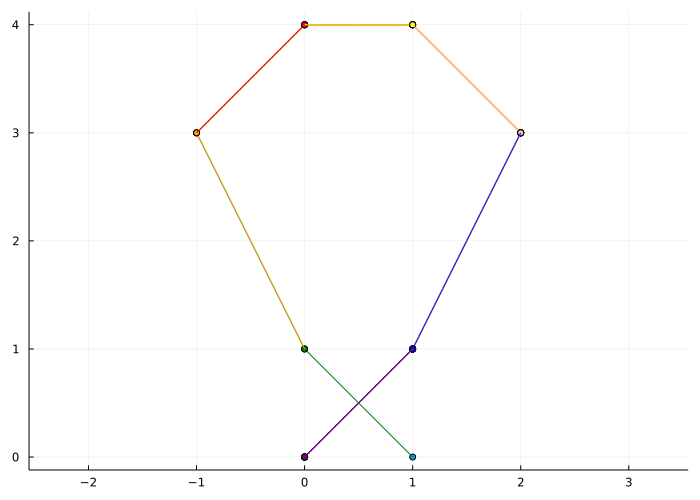

In [38]:
#pts = [(0,0),(1,1),(2,3),(1,4),(0,4),(-1,3),(0,1),(1,0)]
px1 = [0.0, 1, 2, 1, 0, -1, 0, 1]
py1 = [0.0, 1, 3, 4, 4, 3, 1, 0]
animate_bezier(px1, py1)